# sklearn pipeline routine: ColumnTransformer + Pipeline

**Pain point** 

> 데이터처리 과정을 Train에서 학습하고 변환 결과를 Train과 Test 데이터프레임에 적용하거나 생성합니다.

> 여러 처리기를 변수별로 따로 적용하여 여러 파생 변수를 만듭니다.

**데이터처리 과정와 모델 학습을 한 번에**

=> sklearn.compsose.ColumnTransformer + sklearn.pipeline.make_pipeline

> ColumnTransformer : DataFrame에 컬럼별 처리기(StandardScaler, OneHotEncoder, PCA, ...) 적용

> make_pipeline: 여러 단계의 처리 과정을 하나의 모델로 


Ex) 

cat0, cat1는 가변수, cont0, cont1: 표준화 , na_1, na_2: 통과

위 처리를 거친후 대상 변수 failure를  로직스틱 회귀 모델로 학습합니다.


```python
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from skelarn.pipeline import make_pipeline

ct = ColumnTransformer([
    ('ohe', OneHotEncoder(), ['cat0', 'cat1']), #  cat0, cat1은 OneHotEncoder를 적용
    ('std', StandardScaler(), ['cont0', 'cont1']), #  cont0, cont1은 StandardScaler를 적용
    ('pt', 'passthrough', ['na_1', 'na_2']) # na_1, na_2는 통과 
], remainder='drop') # remainder: 'drop' 나머지는 제외, 'passthrough'는 나머지 통과
X = ['cat0', 'cat1', 'cont0', 'cont1', 'na_1', 'na_2']
clf_lr = make_pipeline(ct, LogisticRegression(solver='lbfgs')) # ColumnTransformer->LogisticRegression pipeline 구성
clf_lr.fit(df[X], df['failure'])
```

In [1]:
import pandas as pd
import numpy as np 
import sklearn

for i in [pd, np, sklearn]:
    print(i.__name__, i.__version__)

pandas 0.25.1
numpy 1.18.5
sklearn 0.21.3


In [2]:
# 시각화 모듈을 로드합니다.

import matplotlib.pyplot as plt
import seaborn as sns

**WildBlueberryPollinationSimulationData**

sklearn routine에 대한 예제로 사용할 데이터셋입니다,


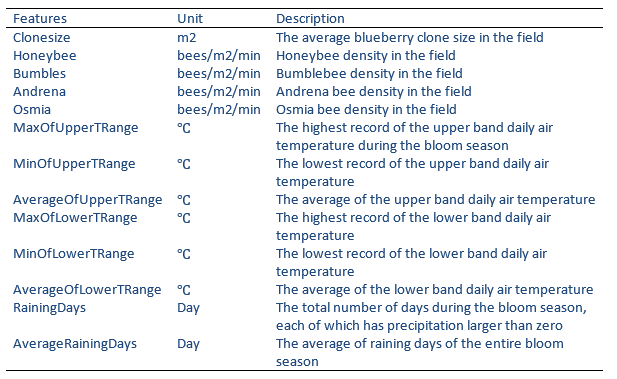


* fruitset: 개체당 결실량
* fruitmass: 과실의 무게
* seeds: 씨앗의 양

**yield: 수확량 (대상 변수)**

설능 측정 지표

$MAE = \sum_{i=1}^n|y_i - \hat{y}_i|$

위 4개 변수는 정확한 단위와 정보는 없는 점을 양해 바랍니다.

In [3]:
df_berry = pd.read_csv('data/WildBlueberryPollinationSimulationData.csv', index_col='Row#')
df_berry.head()

,clonesize,honeybee,bumbles,andrena,osmia,MaxOfUpperTRange,MinOfUpperTRange,AverageOfUpperTRange,MaxOfLowerTRange,MinOfLowerTRange,AverageOfLowerTRange,RainingDays,AverageRainingDays,fruitset,fruitmass,seeds,yield
Row#,,,,,,,,,,,,,,,,,
0,37.5,0.75,0.25,0.25,0.25,86.0,52.0,71.9,62.0,30.0,50.8,16.0,0.26,0.410652,0.408159,31.678898,3813.165795
1,37.5,0.75,0.25,0.25,0.25,86.0,52.0,71.9,62.0,30.0,50.8,1.0,0.10,0.444254,0.425458,33.449385,4947.605663
2,37.5,0.75,0.25,0.25,0.25,94.6,57.2,79.0,68.2,33.0,55.9,16.0,0.26,0.383787,0.399172,30.546306,3866.798965
3,37.5,0.75,0.25,0.25,0.25,94.6,57.2,79.0,68.2,33.0,55.9,1.0,0.10,0.407564,0.408789,31.562586,4303.943030
4,37.5,0.75,0.25,0.25,0.25,86.0,52.0,71.9,62.0,30.0,50.8,24.0,0.39,0.354413,0.382703,28.873714,3436.493543


* 벌의 종류 별 밀도를 나타내는 ['honeybee', 'bumbles', 'andrena', 'osmia'] 는 각각을 아래와 같이 범주화 합니다.

* honeybee

|범위|범주값|
|---|------|
|[0, 0.5)|0|
|[0.5,0.75)]|1|
  
* bumbles

|범위|범주값|
|---|------|
|[0, 0.38)|0|
|[0.38, inf)]|1|
 
* andrena

|범위|범주값|
|---|------|
|[0, 0.38)|0|
|[0.38, 0.5)]|1|
|[0.5, 0.63)]|2|
|[0.63, inf)]|3|

* osmia

|범위|범주값|
|---|------|
|[0, 0.5)|0|
|[0.5, 0.63)]|1|
|[0.63, inf)]|2|

inf: 무한, [a, b) $a \le x < b$

범주화한 컬럼은 각 컬럼명에 _q 를 붙여 추가 합니다. ex) honeybee → honerybee_q

In [4]:
density_cols = ['honeybee', 'bumbles', 'andrena', 'osmia']

dic_q = {
    'honeybee': [0, 0.5, np.inf],
    'bumbles': [0, 0.38, np.inf],
    'andrena': [0, 0.38, 0.5, 0.63, np.inf],
    'osmia': [0, 0.5, 0.63, np.inf]
}
density_q_cols = [i + '_q' for i in density_cols]

df_berry[density_q_cols] = df_berry[density_cols].apply(
    lambda x:pd.cut(x, bins=dic_q[x.name], right=False, labels=np.arange(len(dic_q[x.name]) - 1))
)

In [5]:
df_berry[density_q_cols].apply(lambda x: x.value_counts()).unstack().dropna().to_frame()

0
honeybee_q 0  454.0
           1  323.0
bumbles_q  0  564.0
           1  213.0
andrena_q  0  139.0
           1  232.0
           2  193.0
           3  213.0
osmia_q    0  132.0
           1  229.0
           2  416.0

* 기온을 기록한 컬럼 'MaxOfUpperTRange', 'MinOfUpperTRange', 'AverageOfUpperTRange', 'MaxOfLowerTRange', 
              'MinOfLowerTRange', 'AverageOfLowerTRange'


```python
temp_cols = ['MaxOfUpperTRange', 'MinOfUpperTRange', 'AverageOfUpperTRange', 'MaxOfLowerTRange', 
                'MinOfLowerTRange', 'AverageOfLowerTRange']
df_berry.groupby(temp_cols).size().sort_values().to_frame()
```

을 실행시켜보면, 총 5가지 조합으로 나타납니다. 

5가지 조합으로 범주화하고, 빈도수 순으로 0에서 4으로 레이블로 정한후, 

가장 빈도수가 낮은 범주는 가장 많은 범주로 치환하여 temp라는 파생변수를 생성합니다.

In [6]:
temp_cols = ['MaxOfUpperTRange', 'MinOfUpperTRange', 'AverageOfUpperTRange', 'MaxOfLowerTRange', 
                'MinOfLowerTRange', 'AverageOfLowerTRange']
s_temp_dic = df_berry.groupby(temp_cols).size().rank().astype(int) - 1
s_temp_dic

MaxOfUpperTRange  MinOfUpperTRange  AverageOfUpperTRange  MaxOfLowerTRange  MinOfLowerTRange  AverageOfLowerTRange
69.7              42.1              58.2                  50.2              24.3              41.2                    1
77.4              46.8              64.7                  55.8              27.0              45.8                    2
86.0              52.0              71.9                  62.0              30.0              50.8                    4
89.0              39.0              65.6                  66.0              28.0              45.3                    0
94.6              57.2              79.0                  68.2              33.0              55.9                    3
dtype: int32

In [7]:
# 위의 s_temp_dic에 해당하는 index를 apply를 통해 만들고, 맵핑한 후 최소빈도를 최대 빈도 레이블로 치환합니다.
df_berry['temp'] = df_berry[temp_cols].apply(lambda x: s_temp_dic.loc[tuple(x)], axis=1).replace({0:4})
df_berry['temp'].value_counts()

4    214
3    194
2    188
1    181
Name: temp, dtype: int64

* clonesize는 

10.0 → 12.5, 20.0 → 25.0, 40.0 → 37.5

로 치환하여 clonesize_r이라 파생변수를 추가합니다.

In [8]:
df_berry['clonesize_r'] =  df_berry['clonesize'].replace(
    {10.0: 12.5, 20.0: 25.0, 40.0: 37.5}
)
df_berry['clonesize_r'].value_counts()

12.5    407
25.0    344
37.5     26
Name: clonesize_r, dtype: int64

* Row# 이 4의 배수가 아니면 train, 4의 배수이면 test로 나눕니다.

In [9]:
df_train, df_test = df_berry[df_berry.index % 4 != 0].copy(), df_berry[df_berry.index % 4 == 0].copy()

## Outlier Detection & Clustering

* fruitset, fruitmass, seed 간의 산점도 그래프를 보면, 두 개의 군집이 있을 수 있다는 점을 확인할 수 있습니다.

```python
_, axes = plt.subplots(1, 3, figsize=(16, 4))
for (i, j), ax in zip([('fruitset', 'fruitmass'), ('fruitset', 'seed'), ('fruitmass', 'seed')], axes):
    sns.scatterplot(data=df_berry, x=i, y=i)
plt.tight_layout()
plt.show()
```

선형적 연관성을 고려하여 GaussianMixture 모델을 사용하여 두 개의 군집으로 분리해보세요.

분리하기 전에 LocalOutlierFactor로 보이는 Outlier를 제거하고 진행합니다.

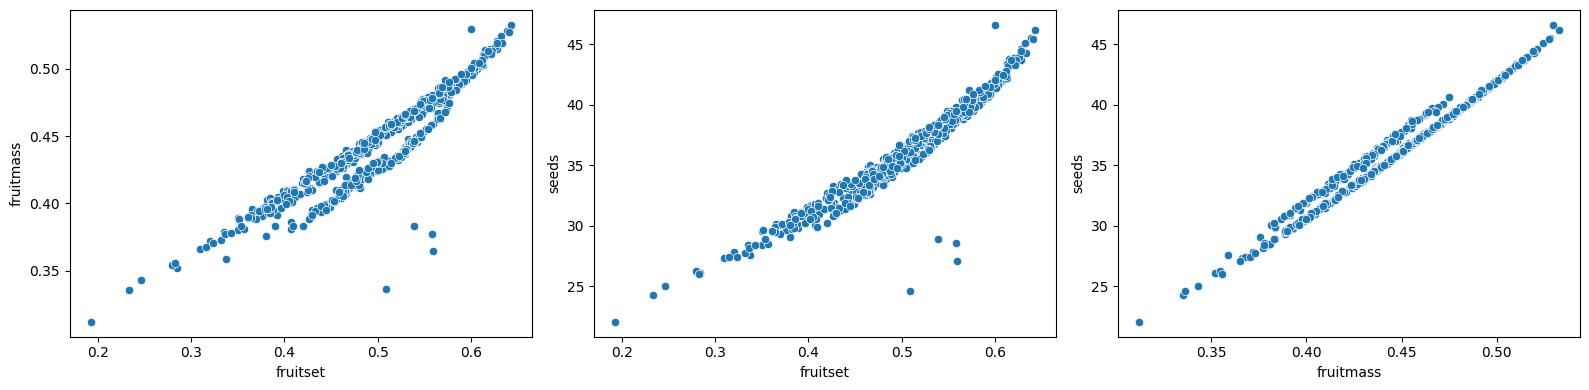

In [10]:
_, axes = plt.subplots(1, 3, figsize=(16, 4))
for (i, j), ax in zip([('fruitset', 'fruitmass'), ('fruitset', 'seeds'), ('fruitmass', 'seeds')], axes):
    sns.scatterplot(data=df_train, x=i, y=j, ax=ax)
plt.tight_layout()
plt.show()

* 다음 두 개의 파생 변수를 

$ mass\_set = \frac{fruitmass}{fruitset}$

$ set\_seeds = \frac{fruitset}{seeds}$

각각은 min_max 정규화를 하여 

ratio 데이터셋을 만듭니다.

Local Outlier Factor를 이용하여 Outlier를 탐색합니다.

**모델 가이드**

Local Outlier Factor의 이웃의 수는 10개 이고, 거리는 아래 식에 기술된 거리를 사용합니다.

$d(x, y) = \sqrt{\sum_{i=1}^n(x_i - y_i)^2}$


````
sklearn.neighbors.LocalOutlierFactor

contamination='auto'

모델 요건을 충족시키기 위한 설정값 외에는 기본값을 사용합니다.

````

df_train에서 아웃라이어로 판별된 관측은 제외하여 df_train2를 만듭니다.

In [11]:
df_ratio = pd.concat([
    (df_train['fruitmass'] / df_train['fruitset']).rename('mass_set'),
    (df_train['fruitset'] / df_train['seeds']).rename('set_seeds')
], axis=1)
df_ratio

,mass_set,set_seeds
Row#,,
1,0.957689,0.013281
2,1.040090,0.012564
3,1.003006,0.012913
5,1.182821,0.011324
6,1.238163,0.010898
...,...,...
770,0.911227,0.013581
771,1.122301,0.011939
773,1.102304,0.012046


In [12]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline

In [13]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import LocalOutlierFactor

In [14]:
X_cols = ['mass_set', 'set_seeds']
lof = make_pipeline(MinMaxScaler(), LocalOutlierFactor(n_neighbors=5, metric='minkowski', p=2, contamination='auto'))
is_outlier = lof.fit_predict(df_ratio[X_cols])

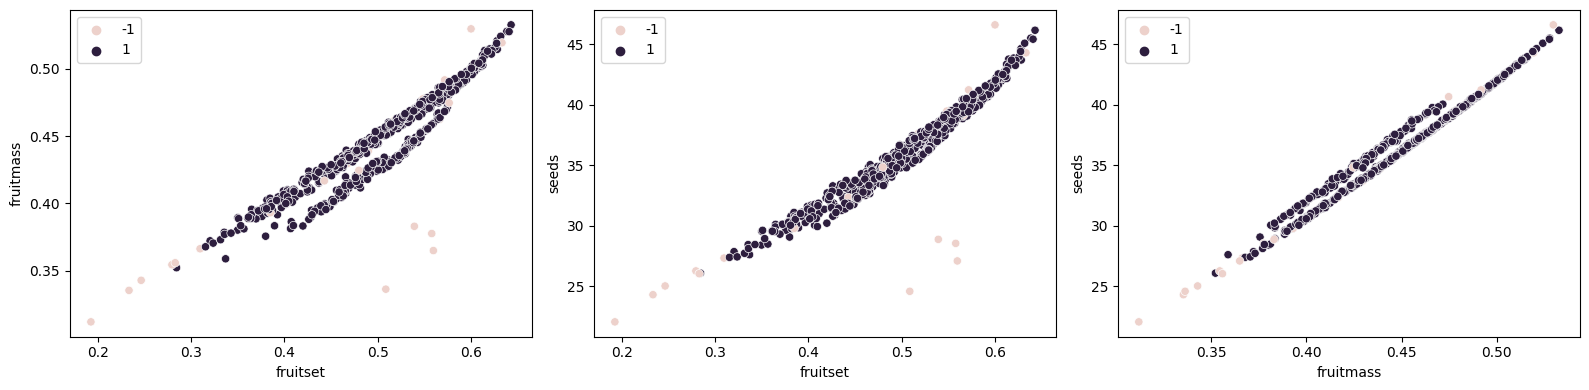

In [15]:
_, axes = plt.subplots(1, 3, figsize=(16, 4))
for (i, j), ax in zip([('fruitset', 'fruitmass'), ('fruitset', 'seeds'), ('fruitmass', 'seeds')], axes):
    sns.scatterplot(data=df_train, x=i, y=j, hue=is_outlier, ax=ax)
plt.tight_layout()
plt.show()

In [16]:
df_train2 = df_train.loc[is_outlier == 1].copy()

* train2 셋을 사용합니다.

**모델 가이드**

Gaussian Mixture 모델의 입력은  fruitset, fruitmass, seeds으로 입니다.

두 개의 군집으로 분리를 합니다. 10번의 시도 중에서 가장 좋은 결과를 사용하고, 초기값은 kmeans를 통해 설정합니다.

Python 함수 가이드
```
sklearn.mixture.GaussianMixture 

random_state=123

모델 요건을 충족시키기 위한 설정값 외에는 기본값을 사용합니다.
```

In [17]:
from sklearn.mixture import GaussianMixture

X_cols = ['fruitset', 'fruitmass', 'seeds']
gm = GaussianMixture(n_components=2, n_init=10, init_params='kmeans', random_state=123)
gm.fit(df_train2[X_cols])

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=2, n_init=10,
                precisions_init=None, random_state=123, reg_covar=1e-06,
                tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
                weights_init=None)

* 학습한 GaussianMixture 모델의 군집의 레이블을 df_train2과 df_test에 변수명을 gmm_label로 하여 추가합니다.

In [18]:
df_train2['gmm_label'] = gm.predict(df_train2[X_cols])
df_test['gmm_label'] = gm.predict(df_test[X_cols])

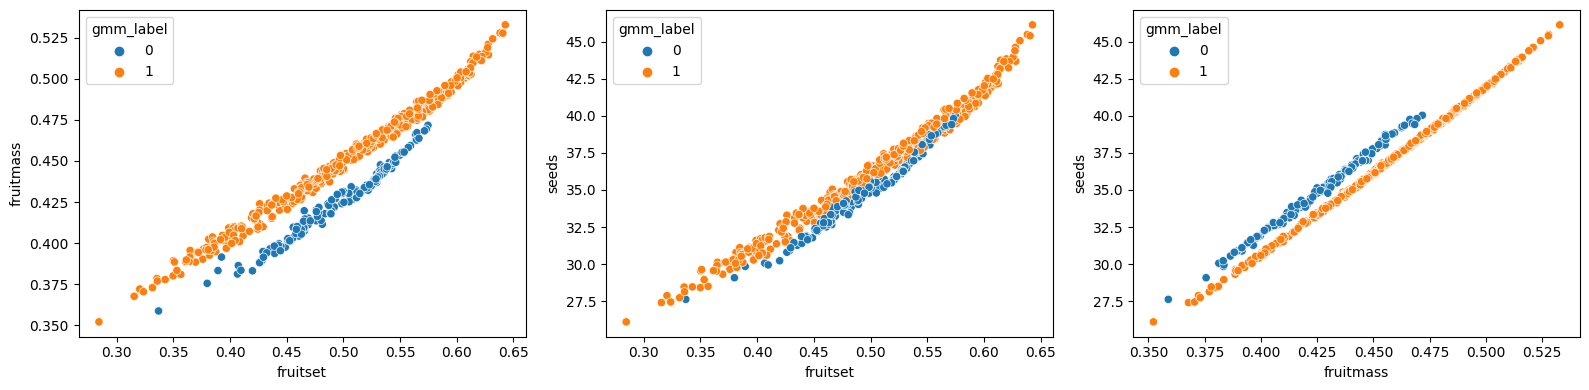

In [19]:
# train2로 결과를 시각화해봅니다.
_, axes = plt.subplots(1, 3, figsize=(16, 4))
for (i, j), ax in zip([('fruitset', 'fruitmass'), ('fruitset', 'seeds'), ('fruitmass', 'seeds')], axes):
    sns.scatterplot(data=df_train2, x=i, y=j, hue='gmm_label', ax=ax)
plt.tight_layout()
plt.show()

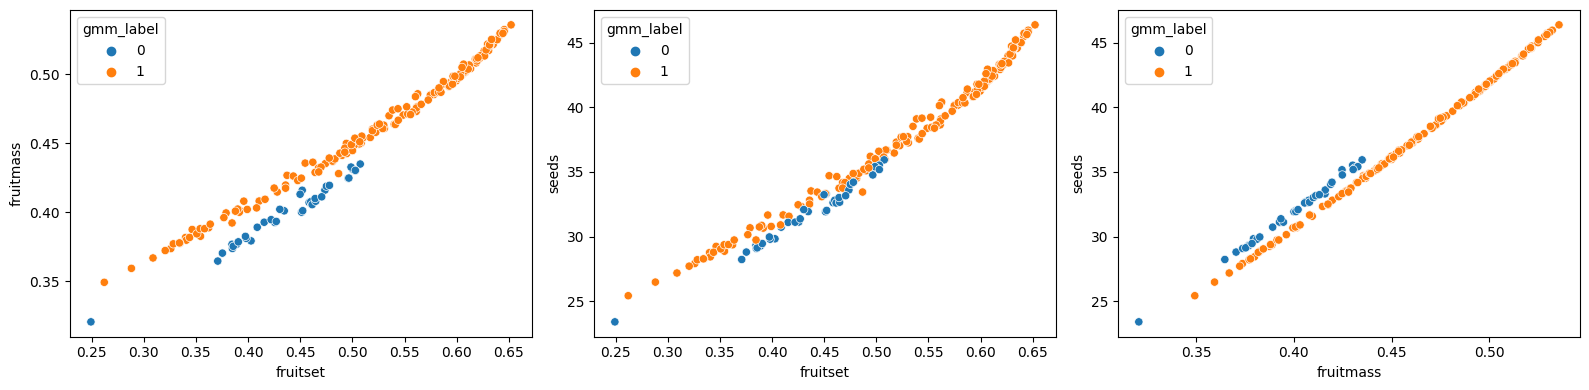

In [20]:
# test2로 결과를 시각화해봅니다.
_, axes = plt.subplots(1, 3, figsize=(16, 4))
for (i, j), ax in zip([('fruitset', 'fruitmass'), ('fruitset', 'seeds'), ('fruitmass', 'seeds')], axes):
    sns.scatterplot(data=df_test, x=i, y=j, hue='gmm_label', ax=ax)
plt.tight_layout()
plt.show()

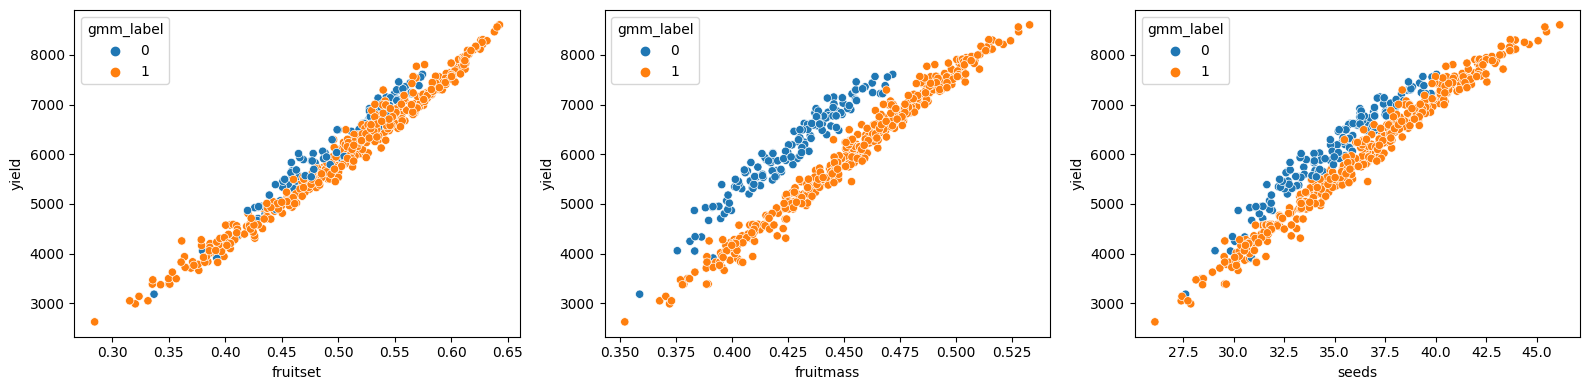

In [21]:
# 대상값인 yield와 (fruitset, fruitmass, seeds)와의 scatter plot을 봅니다.
_, axes = plt.subplots(1, 3, figsize=(16, 4))
for i, ax in zip(['fruitset', 'fruitmass', 'seeds'], axes):
    sns.scatterplot(data=df_train2, x=i, y='yield', hue='gmm_label', ax=ax)
plt.tight_layout()
plt.show()

## Linear Regression

학습 데이터셋은 이상치를 제외하고 gmm_label을 추가한 train2를 사용합니다.

모델에 대한 평가는 test를 사용합니다.

수확량(yield)을 예측하는 회귀 3가지 회귀 모델을 만듭니다. 평가 지표는 서두에 언급했듯이 MAE를 사용합니다. 


* 모델 1 

   입력 변수 및 전처리

  'clonesize_r', 'honeybee_q', 'bumbles_q', 'andrena_q', 'osmia_q','temp'는 오름순으로 범주 수준의 첫 번째는 제외하고 가변수화 합니다.

  'fruitset', 'fruitmass', 'seeds'는 표준화를 합니다.

  모델 설정]

  다음과 같은 손실함수를 지니는 선형 모델을 사용합니다.

    $loss = \sum_{i=1}^{n}(y_i - \hat{y}_i)^2$

  python 함수 가이드
 
```
   전처리는 sklearn.preprocessing 모듈 내에 있는 기능을 사용하세요.

   선형 모델은 sklearn.linear_model에서 사용합니다.
```


* 모델 2

   입력 변수  및 전처리

   모델 1에서 'gmm_label'를  가변수화 대상 변수로 추가하고 나머지 설정 동일하게 하여, gmm_label만 추가하고 나머지 설정은 동일하게 합니다.


* 모델 3

   gmm_label 별로 모델 1에 대한 모델을 만듭니다. gmm_label이 두 종류이니 두 개의 모델을 생성하는 겁니다. gmm_label에 따라 예측결과를 만듭니다.

In [22]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import mean_absolute_error

X_categ = ['clonesize_r', 'honeybee_q', 'bumbles_q', 'andrena_q', 'osmia_q', 'temp']
X_cont = ['fruitset', 'fruitmass', 'seeds']
X_cols =  X_categ + X_cont
ct = ColumnTransformer([
    ('ohe', OneHotEncoder(drop='first', categories='auto'), X_categ),
    ('std', StandardScaler(), X_cont)
])
reg_lr = make_pipeline(ct, LinearRegression())
reg_lr.fit(df_train2[X_cols], df_train2['yield'])

(
    mean_absolute_error(df_train2['yield'], reg_lr.predict(df_train2[X_cols])),
    mean_absolute_error(df_test['yield'], reg_lr.predict(df_test[X_cols]))
)

(107.67603211761806, 118.85888365618959)

In [25]:
X_categ = ['clonesize_r', 'honeybee_q', 'bumbles_q', 'andrena_q', 'osmia_q', 'temp', 'gmm_label']
X_cont = ['fruitset', 'fruitmass', 'seeds']
X_cols = X_categ + X_cont
ct = ColumnTransformer([
    ('ohe', OneHotEncoder(drop='first', categories='auto'), X_categ),
    ('std', StandardScaler(), X_cont)
])
reg_lr = make_pipeline(ct, LinearRegression())
reg_lr.fit(df_train2[X_cols], df_train2['yield'])

(
    mean_absolute_error(df_train2['yield'], reg_lr.predict(df_train2[X_cols])),
    mean_absolute_error(df_test['yield'], reg_lr.predict(df_test[X_cols]))
)

(107.65072705967756, 118.80002575306325)

In [26]:
X_categ = ['clonesize_r', 'honeybee_q', 'bumbles_q', 'andrena_q', 'osmia_q', 'temp']
X_cont = ['fruitset', 'fruitmass', 'seeds']
X_cols =  X_categ + X_cont
def build_lr():
    ct = ColumnTransformer([
        ('ohe', OneHotEncoder(drop='first', categories='auto'), X_categ),
        ('std', StandardScaler(), X_cont)
    ])
    return make_pipeline(ct, LinearRegression())

s_lr = df_train2.groupby('gmm_label').apply(lambda x:
    build_lr().fit(x[X_cols], x['yield'])
)

df_prd = df_train2.groupby('gmm_label').apply(lambda x:
    pd.DataFrame({'prd': s_lr[x.name].predict(x[X_cols])}, index=x.index)
)
mae_train = mean_absolute_error(df_train2['yield'].sort_index(), df_prd.sort_index()['prd'])

df_prd = df_test.groupby('gmm_label').apply(lambda x:
    pd.DataFrame({'prd': s_lr[x.name].predict(x[X_cols])}, index=x.index)
)
mae_test = mean_absolute_error(df_test['yield'].sort_index(), df_prd.sort_index()['prd'])

(mae_train, mae_test)

(100.71446210393385, 116.45044789983137)

## Random Forest Classifier

학습 데이터셋은 이상치를 제외하고 gmm_label을 추가한 train2를 사용합니다.

모델에 대한 평가는 test를 사용합니다.

수확량(yield)을 예측하는 회귀 3가지 회귀 모델을 만듭니다. 평가 지표는 서두에 언급했듯이 MAE를 사용합니다. 


* 모델 1 

   입력 변수 및 전처리]

  'temp', 'gmm_label'은 범주의 수준에 오름순으로 가변수화 합니다.

  연속형 변수 'fruitset', 'fruitmass', 'seeds'는 아무런 처리 하지 않습니다.
  
  서수형 변수 'clonesize_r', 'honeybee_q', 'bumbles_q', 'andrena_q', 'osmia_q'도 아무런 처리하지 않습니다.
  
  입력 변수의 순서는 temp의 가변수, 표준화변수, 서수형 변수로 하고 각 유형 내에서 변수의 순서는 위에서 제시한 순서를 따릅니다. 
  
  **입력 변수의 순서에 따라 결과가 달라질 수 있으니 유의하세요.**

  모델의 설정]
  
    Random Forest의 설정은 트리의 수는 300개, 최대 깊이는 8, 단말 노드의 최소 샘플수는 2 입니다.
 
```
   전처리는 sklearn.preprocessing 모듈 내에 있는 기능을 사용하세요.

   sklearn.ensembe.RandomForestClassifier를 사용하고 random_state=123
   
   기술한 설정값과 위에서 제시한 설정외의 모든 값은 모듈에 설정된 기본값을 사용합니다.
```

* 모델 2

  입력 변수 및 전처리

  'temp', 'gmm_label'은 범주의 수준에 오름순으로 가변수화 합니다.

  연속형 변수 'fruitset', 'fruitmass', 'seeds'는 PCA(주성분 분석)을 통해 나온 가장 분산 설명이 높은 컴포넌트 1개를 사용합니다. 
  
      주성분 분석 모델은 train2만을 사용합니다. 
      
      입력변수 'fruitset', 'fruitmass', 'seeds'은 표준화 합니다.
  
  서수형 변수 'clonesize_r', 'honeybee_q', 'bumbles_q', 'andrena_q', 'osmia_q'도 아무런 처리하지 않습니다.
  
  입력 변수의 순서는 temp의 가변수, PCA 컴포넌트, 서수형 변수로 하고 각 유형 내에서 변수의 순서는 위에서 제시한 순서를 따릅니다. 
  
  **입력 변수의 순서에 따라 결과가 달라질 수 있으니 유의하세요.**

  모델의 설정]
  
    Random Forest의 설정은 트리의 수는 300개, 최대 깊이는 8, 단말 노드의 최소 샘플수는 2 입니다.


  python 함수 가이드
 
```
   전처리는 sklearn.preprocessing 모듈 내에 있는 기능을 사용하세요.

   sklearn.ensembe.RandomForestClassifier를 사용하고 random_state=123
   
   sklearn.decompostion.PCA 의 random_state=123을 사용합니다.
   
   기술한 설정값과 위에서 제시한 설정외의 모든 값은 모듈에 설정된 기본값을 사용합니다.
```

In [27]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_absolute_error

X_nominal = ['temp', 'gmm_label']
X_cont = ['fruitset', 'fruitmass', 'seeds']
X_ord = ['clonesize_r', 'honeybee_q', 'bumbles_q', 'andrena_q', 'osmia_q']

X_cols = X_nominal +  X_categ + X_cont
ct = ColumnTransformer([
    ('ohe', OneHotEncoder(categories='auto'), X_nominal),
    ('pt', 'passthrough', X_cont + X_ord)
])
reg_rf = make_pipeline(ct, RandomForestRegressor(max_depth=8, min_samples_leaf=2, n_estimators=300))
reg_rf.fit(df_train2[X_cols], df_train2['yield'])

(
    mean_absolute_error(df_train2['yield'], reg_rf.predict(df_train2[X_cols])),
    mean_absolute_error(df_test['yield'], reg_rf.predict(df_test[X_cols]))
)

(63.590136672732164, 159.13766838421148)

In [28]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

X_nominal = ['temp', 'gmm_label']
X_cont = ['fruitset', 'fruitmass', 'seeds']
X_ord = ['clonesize_r', 'honeybee_q', 'bumbles_q', 'andrena_q', 'osmia_q']

X_cols = X_nominal +  X_categ + X_cont
ct = ColumnTransformer([
    ('ohe', OneHotEncoder(categories='auto'), X_nominal),
    ('pca', make_pipeline(StandardScaler(), PCA(n_components=2)), X_cont),
    ('pt', 'passthrough', X_cont + X_ord)
])
reg_rf = make_pipeline(ct, RandomForestRegressor(max_depth=8, min_samples_leaf=2, n_estimators=300))
reg_rf.fit(df_train2[X_cols], df_train2['yield'])

(
    mean_absolute_error(df_train2['yield'], reg_rf.predict(df_train2[X_cols])),
    mean_absolute_error(df_test['yield'], reg_rf.predict(df_test[X_cols]))
)

(62.24116553846236, 164.1618823542727)

# Voting 기법을 활용

성능이 비슷한 여러 개의 모델을 합친 Ensemble 모델 구성합니다.

In [33]:
from sklearn.ensemble import VotingRegressor
from sklearn.model_selection import cross_val_score

reg_vt = VotingRegressor([
    ('lr', reg_lr), # 첫번째 요소는 모델명, 두 번째
    ('rf', reg_rf)
])#.fit(df_train2[X_cols], df_train2['yield'])
cross_val_score(reg_vt, df_train2[X_cols], df_train2['yield'], cv=5, scoring='neg_mean_absolute_error')

array([-139.13152136,  -92.66816076, -130.56524263, -132.60996467,
       -155.76571678])